# 01_clean.ipynb

This notebook cleans raw StockX sneaker resale data for multiple models,
removing outliers, rare sizes, and formatting inconsistent price fields.
It outputs one cleaned dataset per model, plus a combined dataset for analysis.


In [72]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

DATA_RAW = "C:\\Projects/sneaker_elasticity/data_raw/"
DATA_CLEAN = "C:\\Projects/sneaker_elasticity/data_clean/"

In [73]:
df_adidas = pd.read_csv(os.path.join(DATA_RAW, "Adidas_StockX.csv"))
df_jordan = pd.read_csv(os.path.join(DATA_RAW, "AirJordan_StockX.csv"))
df_raw = pd.concat([df_adidas, df_jordan], ignore_index=True)

print("Combined raw shape:", df_raw.shape)
df_raw.head()

Combined raw shape: (31201, 11)


,Brand,Model,Color,Retail_Price,Release_Date,Price_Premium,Avg_Sale_Price,Date_of_Sale,Time_of_Sale,Sneaker_Size,Sale_Price
0,Adidas,adidas Yeezy Boost 350 V2 Beluga 2.0,GREY/BOLD ORANGE/DARK GREY,$220,11/25/17,86.40%,$391,"Sunday, February 11, 2018",2:50 AM EST,14,$410
1,Adidas,adidas Yeezy Boost 350 V2 Beluga 2.0,GREY/BOLD ORANGE/DARK GREY,$220,11/25/17,86.40%,$391,"Sunday, February 11, 2018",2:36 AM EST,8.5,$360
2,Adidas,adidas Yeezy Boost 350 V2 Beluga 2.0,GREY/BOLD ORANGE/DARK GREY,$220,11/25/17,86.40%,$391,"Sunday, February 11, 2018",2:16 AM EST,9,$369
3,Adidas,adidas Yeezy Boost 350 V2 Beluga 2.0,GREY/BOLD ORANGE/DARK GREY,$220,11/25/17,86.40%,$391,"Sunday, February 11, 2018",2:05 AM EST,10,$395
4,Adidas,adidas Yeezy Boost 350 V2 Beluga 2.0,GREY/BOLD ORANGE/DARK GREY,$220,11/25/17,86.40%,$391,"Sunday, February 11, 2018",1:53 AM EST,9.5,$395


In [74]:
def clean_sneaker_data(df, model_name, min_sales_per_size=10, low_q=0.10, high_q=0.90):
    """Clean resale data for one sneaker model."""
    model_df = df[df['Model'] == model_name].copy()
    
    model_df.loc[:, 'Sale_Price'] = (
        model_df['Sale_Price']
        .replace('[\$,]', '', regex=True)
        .astype(float)
    )
    model_df.loc[:, 'Retail_Price'] = (
        model_df['Retail_Price']
        .replace('[\$,]', '', regex=True)
        .astype(float)
    )
    model_df.loc[:, 'Date_of_Sale'] = pd.to_datetime(model_df['Date_of_Sale'], errors='coerce')
    
    valid_sizes = model_df['Sneaker_Size'].value_counts()
    valid_sizes = valid_sizes[valid_sizes >= min_sales_per_size].index
    model_df = model_df[model_df['Sneaker_Size'].isin(valid_sizes)]

    Q1, Q3 = model_df['Sale_Price'].quantile([low_q, high_q])
    IQR = Q3 - Q1
    model_df = model_df[(model_df['Sale_Price'] >= Q1 - 1.5 * IQR) & 
                        (model_df['Sale_Price'] <= Q3 + 1.5 * IQR)]
    
    return model_df


In [75]:
models = [
    "adidas Yeezy Boost 350 V2 Core Black White",
    "adidas Yeezy Boost 350 V2 Zebra",
    "Jordan 1 Retro Chicago (2015)",
    "Jordan 1 Retro UNC"
]

clean_dfs = []

for model in models:
    clean_df = clean_sneaker_data(df_raw, model)
    clean_df["Model"] = model
    clean_dfs.append(clean_df)
    
    filename = model.replace(" ", "_").replace("/", "_").lower() + ".csv"
    clean_df.to_csv(os.path.join(DATA_CLEAN, filename), index=False)


In [76]:
df_clean_all = pd.concat(clean_dfs, ignore_index=True)
df_clean_all.to_csv(os.path.join(DATA_CLEAN, "all_models_clean.csv"), index=False)

df_clean_all.head()


,Brand,Model,Color,Retail_Price,Release_Date,Price_Premium,Avg_Sale_Price,Date_of_Sale,Time_of_Sale,Sneaker_Size,Sale_Price
0,Adidas,adidas Yeezy Boost 350 V2 Core Black White,CORE BLACK/CORE WHITE/CORE BLACK,220.0,12/17/16,215.90%,$709,2018-02-11 00:00:00,3:25 AM EST,11,695.0
1,Adidas,adidas Yeezy Boost 350 V2 Core Black White,CORE BLACK/CORE WHITE/CORE BLACK,220.0,12/17/16,215.90%,$709,2018-02-10 00:00:00,10:30 PM EST,10,769.0
2,Adidas,adidas Yeezy Boost 350 V2 Core Black White,CORE BLACK/CORE WHITE/CORE BLACK,220.0,12/17/16,215.90%,$709,2018-02-10 00:00:00,8:26 AM EST,8.5,735.0
3,Adidas,adidas Yeezy Boost 350 V2 Core Black White,CORE BLACK/CORE WHITE/CORE BLACK,220.0,12/17/16,215.90%,$709,2018-02-10 00:00:00,5:18 AM EST,14,690.0
4,Adidas,adidas Yeezy Boost 350 V2 Core Black White,CORE BLACK/CORE WHITE/CORE BLACK,220.0,12/17/16,215.90%,$709,2018-02-09 00:00:00,8:05 PM EST,10,750.0


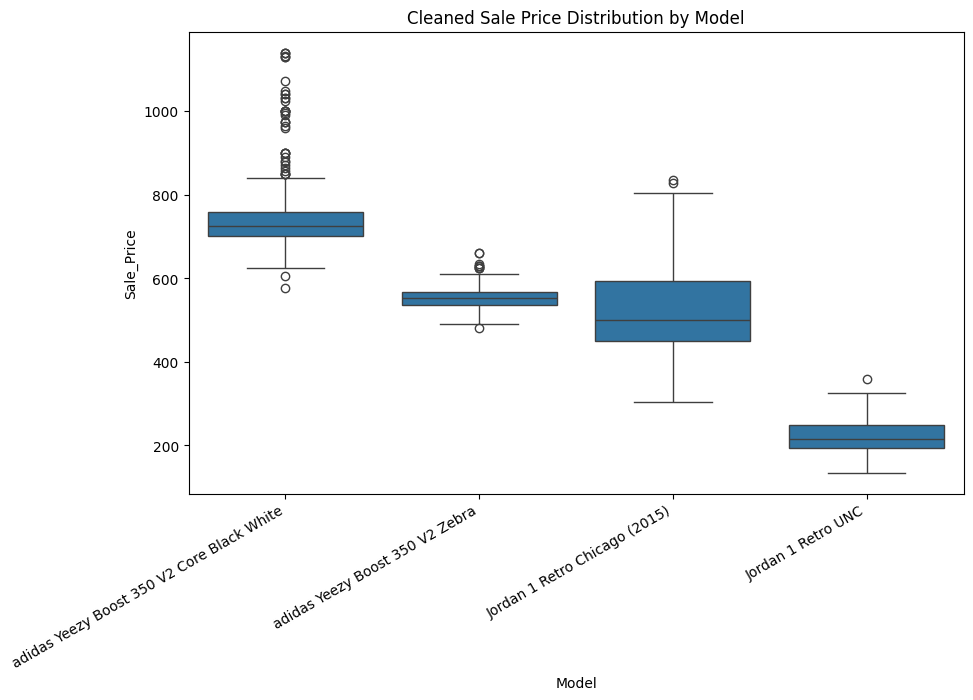

,count,unique,top,freq
Model,,,,
Jordan 1 Retro Chicago (2015),482.0,165.0,450.0,19.0
Jordan 1 Retro UNC,480.0,90.0,250.0,59.0
adidas Yeezy Boost 350 V2 Core Black White,461.0,131.0,700.0,41.0
adidas Yeezy Boost 350 V2 Zebra,451.0,101.0,550.0,30.0


In [77]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_clean_all, x="Model", y="Sale_Price")
plt.xticks(rotation=30, ha='right')
plt.title("Cleaned Sale Price Distribution by Model")
plt.show()

df_clean_all.groupby("Model")["Sale_Price"].describe()


## Summary
- Cleaned 4 sneaker models from StockX.
- Removed outliers and inconsistent pricing.
- Output both individual and combined CSVs for analysis.

Next: 02_features.ipynb → tranform & create features
